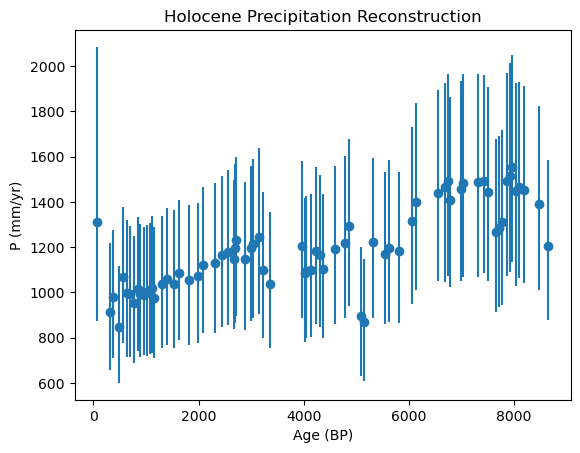

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import lognorm, norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Load data
precip_df = pd.read_excel('Precip_from_drip_rates.xlsx')
drip_df = pd.read_excel('drip_rate_percentiles.xlsx')

# Interp drip to RAN-15 ages
interp_med = interp1d(drip_df['age_calBP'], drip_df['DR_med'], bounds_error=False, fill_value='extrapolate')
interp_pc25 = interp1d(drip_df['age_calBP'], drip_df['DR_pc25'], bounds_error=False, fill_value='extrapolate')
interp_pc75 = interp1d(drip_df['age_calBP'], drip_df['DR_pc75'], bounds_error=False, fill_value='extrapolate')

# Filter to RAN-15 range, interp drip
precip_df = precip_df[(precip_df['Age (yr, BP)'] >= 73) & (precip_df['Age (yr, BP)'] <= 8807.34)].copy()
precip_df['DR_med'] = interp_med(precip_df['Age (yr, BP)'])
precip_df['DR_pc25'] = interp_pc25(precip_df['Age (yr, BP)'])
precip_df['DR_pc75'] = interp_pc75(precip_df['Age (yr, BP)'])

# Actual regression params from fit
a_h_mean, a_h_std = 0.0102, 0.0025
b_h_mean, b_h_std = -0.0151, 0.0393
resid_h_std = 0.0217
a_y_mean, a_y_std = 0.4393, 0.266
b_y_mean, b_y_std = 0.1074, 0.041
resid_y_std = 0.0249

N = 10000
results = []

for _, row in precip_df.iterrows():
    age = row['Age (yr, BP)']
    drip_med = row['DR_med']
    drip_p25 = row['DR_pc25']
    drip_p75 = row['DR_pc75']
    
    if np.isnan(drip_med) or drip_p25 >= drip_p75 or drip_med <= 0:
        continue
    
    sigma = (np.log(drip_p75) - np.log(drip_p25)) / (2 * norm.ppf(0.75))
    mu = np.log(drip_med)
    drip_dist = lognorm(s=sigma, scale=np.exp(mu))
    
    T_mean = row['RAN15-MAAT(°C)']
    T_std = 2.6
    T_dist = norm(loc=T_mean, scale=T_std)
    
    drip_samples = drip_dist.rvs(N)
    a_h_samples = norm(loc=a_h_mean, scale=a_h_std).rvs(N)
    b_h_samples = norm(loc=b_h_mean, scale=b_h_std).rvs(N)
    resid_h_samples = norm(loc=0, scale=resid_h_std).rvs(N)
    PT_h_samples = a_h_samples * drip_samples + b_h_samples + resid_h_samples
    
    a_y_samples = norm(loc=a_y_mean, scale=a_y_std).rvs(N)
    b_y_samples = norm(loc=b_y_mean, scale=b_y_std).rvs(N)
    resid_y_samples = norm(loc=0, scale=resid_y_std).rvs(N)
    PT_y_samples = a_y_samples * np.maximum(PT_h_samples, 0) + b_y_samples + resid_y_samples  # Clip PT_h >=0 to avoid negatives
    
    T_samples = T_dist.rvs(N)
    P_daily_samples = PT_y_samples * T_samples
    P_annual_samples = P_daily_samples * 365.25
    
    P_med = np.median(P_annual_samples)
    P_pc25, P_pc75 = np.percentile(P_annual_samples, [25, 75])
    results.append({'age': age, 'P_med': P_med, 'P_pc25': P_pc25, 'P_pc75': P_pc75})

result_df = pd.DataFrame(results)
result_df.to_csv('p_reconstruction.csv', index=False)

plt.errorbar(result_df['age'], result_df['P_med'], yerr=[result_df['P_med'] - result_df['P_pc25'], result_df['P_pc75'] - result_df['P_med']], fmt='o')
plt.xlabel('Age (BP)')
plt.ylabel('P (mm/yr)')
plt.title('Holocene Precipitation Reconstruction')
plt.savefig('p_plot.png')
plt.show()